In [1]:
import functools
import tensorflow as tf
from core.model import ModelMNIST10x10_base, swish
from core.hessian import diagonal_hessians_highrank

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.GradientDescentOptimizer(1.0)):
        self.batch_ratio = max(1.0, 1.0 * batch_size / 50000.0)
        super(Implement, self).__init__(batch_size, opt, activation=tf.nn.relu)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        hessis = diagonal_hessians_highrank(
                 cost, var_refs, gradients=grads,
                 aggregation_method=None, colocate_gradients_with_ops=True)
        
        second_order_grads = []
        for l, g, h, v in zip(range(len(grads)), grads, hessis, var_refs):
            shape = g.shape
            is_calculating_hessian = True #('conv' in v.name)# and ('weight' in v.name)
            if is_calculating_hessian:
                
                h_inv = 1.0 / (tf.reshape(tf.abs(h+1e-6), shape))
#                h_inv_clipped = h_inv
#                h_inv_clipped = tf.clip_by_norm(h_inv, 1.0)
                h_inv_clipped = tf.clip_by_value(h_inv, 0.0, 2.0)
                delta = tf.multiply(h_inv_clipped, g)
            else:
                delta = g
            second_order_grads.append(delta)
            
            tf.summary.histogram('{}'.format(v.name.replace(':', '_')), v)
            tf.summary.histogram('{}/gradient'.format(v.name.replace(':', '_')), g)
            tf.summary.histogram('{}/delta'.format(v.name.replace(':', '_')), delta)
            if is_calculating_hessian:
                tf.summary.histogram('{}/hessian/diag'.format(v.name.replace(':', '_')), h)
                tf.summary.histogram('{}/hessian/inv/diag'.format(v.name.replace(':', '_')), h_inv)
                tf.summary.histogram('{}/hessian/inv/clip/diag'.format(v.name.replace(':', '_')), h_inv_clipped)
            
        return second_order_grads

In [2]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

model = Implement(batch_size=50000)

[1204 12:07:29 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1204 12:07:30 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.


In [3]:
from core.utils import loop

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.Session(config=config)
history = loop(sess, model, 30, './summary/9_3_incomplete_saddle_less_second_order_optimization_batch_50000')

env: CUDA_VISIBLE_DEVICES=0
[INFO] session initialized
[INFO] [0000] [train] cost:0.863 accuracy:0.099 elapsed:4.996sec [valid] cost:0.482 accuracy:0.140 elapsed:0.245sec
[INFO] [0001] [train] cost:0.466 accuracy:0.159 elapsed:0.780sec [valid] cost:0.392 accuracy:0.243 elapsed:0.010sec
[INFO] [0002] [train] cost:0.390 accuracy:0.266 elapsed:0.762sec [valid] cost:0.362 accuracy:0.304 elapsed:0.009sec
[INFO] [0003] [train] cost:0.352 accuracy:0.360 elapsed:0.830sec [valid] cost:0.402 accuracy:0.376 elapsed:0.009sec
[INFO] [0004] [train] cost:0.347 accuracy:0.423 elapsed:0.741sec [valid] cost:0.320 accuracy:0.389 elapsed:0.009sec
[INFO] [0005] [train] cost:0.301 accuracy:0.447 elapsed:0.758sec [valid] cost:0.254 accuracy:0.490 elapsed:0.009sec
[INFO] [0006] [train] cost:0.260 accuracy:0.511 elapsed:0.739sec [valid] cost:0.239 accuracy:0.563 elapsed:0.010sec
[INFO] [0007] [train] cost:0.233 accuracy:0.581 elapsed:0.749sec [valid] cost:0.218 accuracy:0.618 elapsed:0.009sec
[INFO] [0008] [tr

average elapsed time train:0.830110sec valid:0.010461sec


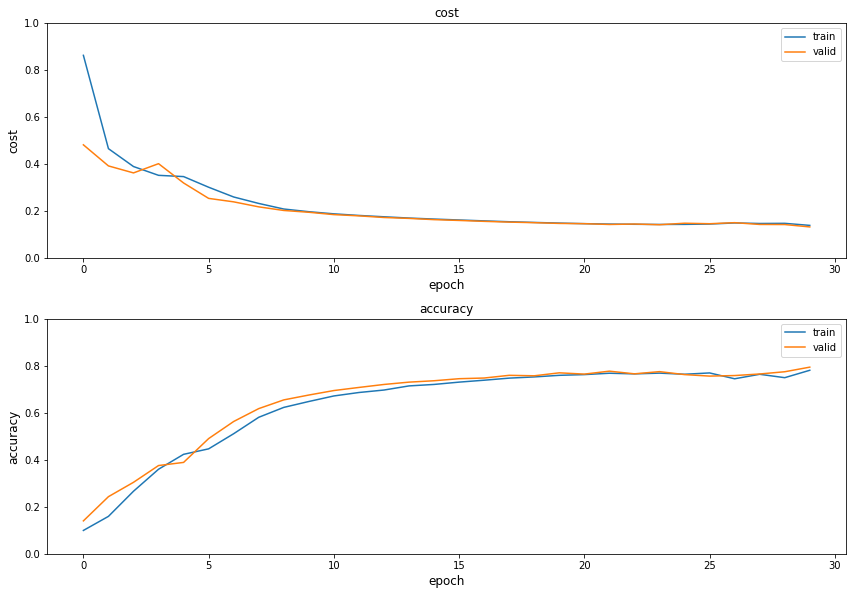

In [4]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)